# Kaggle Bike Sharing Demand Dataset
## Introduction
Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.<br>

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this kaggle competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.
<br> Source : https://www.kaggle.com/c/bike-sharing-demand/overview

## Objective
In this competition, we need to predict count of the bike rental demand for the provided test data. I chose to use this competition as a means to get familiar with using AWS Sagemaker tool on Amazon cloud and its capabilities.

## Dataset
Data set can be obtained from the link :https://www.kaggle.com/c/bike-sharing-demand/data.  One needs to sign in to obtain this data. The data column information has already been given on the website as 'count', 'season', 'holiday', 'workingday', 'weather', 'temp','atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'dayofweek'.

<br>
We are provided with hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. We must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

## Metric
 Root Mean Squared Logarithmic Error (RMSLE) is used as a metric for evaluation at competition.We however while modelling will use rmse to evaluate as they are both proportional. RMSLE is calculated as : <br>
 <img src="img-metric.JPG" style="height:40px; widght:100px" ></img>

### Importing libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Loading data

In [2]:
columns = ['count', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'dayofweek','hour']

In [3]:
df = pd.read_csv('train.csv', parse_dates=['datetime'])
df_test = pd.read_csv('test.csv', parse_dates=['datetime'])

In [7]:
# Take a peek
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,dayofweek,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,5,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,5,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,5,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,5,4


### Adding features from the data column 

In [4]:
# We need to convert datetime to numeric for training.
# Let's extract key features into separate numeric columns
def add_features(df):
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['hour'] = df['datetime'].dt.hour

In [5]:
add_features(df)
add_features(df_test)

In [8]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,dayofweek,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,5,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,5,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,5,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,5,4


In [29]:
df.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                float64
year                   int64
month                  int64
day                    int64
dayofweek              int64
hour                   int64
dtype: object

### Check for any trends
#### monthly

In [14]:
group_month = df.groupby(['month'])
average_by_month = group_month['count'].mean()

Text(0.5,1,'Rental Count by Month')

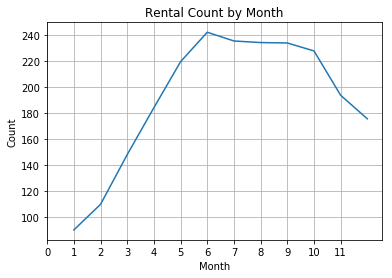

In [15]:
plt.plot(average_by_month.index,average_by_month)
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(np.arange(12))
plt.grid(True)
plt.title('Rental Count by Month')

#### Does this repeat every year?

Text(0.5,1,'Rental Count by Year,Month')

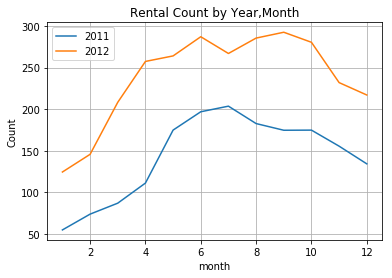

In [16]:
group_year_month = df.groupby(['year','month'])
average_year_month = group_year_month['count'].mean()
for year in average_year_month.index.levels[0]:
    plt.plot(average_year_month[year].index,average_year_month[year],label=year)
    
plt.legend()    
plt.xlabel('month')
plt.ylabel('Count')
plt.grid(True)
plt.title('Rental Count by Year,Month')

#### What about hourly? 

Text(0.5,1,'Rental Count Average by hour')

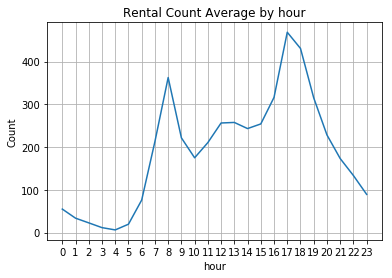

In [17]:
group_hour = df.groupby(['hour'])
average_by_hour = group_hour['count'].mean()
plt.plot(average_by_hour.index,average_by_hour)
plt.xlabel('hour')
plt.ylabel('Count')
plt.xticks(np.arange(24))
plt.grid(True)
plt.title('Rental Count Average by hour')

Does the hourly pattern stay same in both years?

Text(0.5,1,'Rental Count Average by Year,Hour')

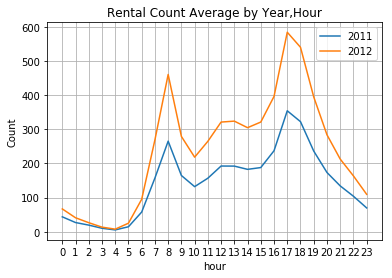

In [18]:
group_year_hour = df.groupby(['year','hour'])
average_year_hour = group_year_hour['count'].mean()
for year in average_year_hour.index.levels[0]:
    plt.plot(average_year_hour[year].index,average_year_hour[year],label=year)
    
plt.legend()    
plt.xlabel('hour')
plt.ylabel('Count')
plt.xticks(np.arange(24))
plt.grid(True)
plt.title('Rental Count Average by Year,Hour')

There is definately a repeating monthly and hourly pattern. 

Does this pattern remain same for weekday and weekend?

Text(0.5,1,'Rental Count Average by Working Day,Hour')

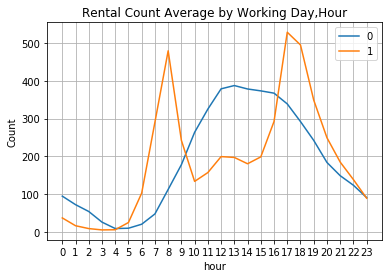

In [19]:
group_workingday_hour = df.groupby(['workingday','hour'])
average_workingday_hour = group_workingday_hour['count'].mean()
for workingday in average_workingday_hour.index.levels[0]:
    plt.plot(average_workingday_hour[workingday].index,average_workingday_hour[workingday],label=workingday)
    
plt.legend()    
plt.xlabel('hour')
plt.ylabel('Count')
plt.xticks(np.arange(24))
plt.grid(True)
plt.title('Rental Count Average by Working Day,Hour')

Here we can see that on weekdays people use bike more in morning and in evening possible commuting to work. While on weekend perhaps they use it more in afternoon for a leisure trip.

### Correlation to find strongly related features

In [6]:
# Correlation will indicate how strongly features are related to the output
df.corr()['count']

season        0.163439
holiday      -0.005393
workingday    0.011594
weather      -0.128655
temp          0.394454
atemp         0.389784
humidity     -0.317371
windspeed     0.101369
casual        0.690414
registered    0.970948
count         1.000000
year          0.260403
month         0.166862
day           0.019826
dayofweek    -0.002283
hour          0.400601
Name: count, dtype: float64

Hour is quite correlated as compared to other columns

### Check distribution of counts

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f986fdfc8d0>]],
      dtype=object)

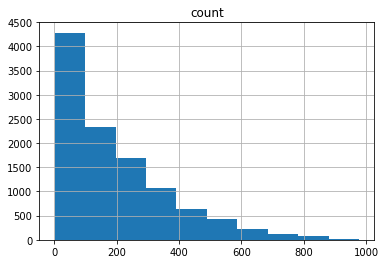

In [12]:
df.hist(column='count')

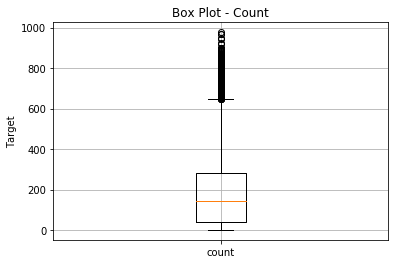

In [13]:
plt.boxplot([df['count']], labels=['count'])
plt.title('Box Plot - Count')
plt.ylabel('Target')
plt.grid(True)

We can see that the distribution is skewed and also there are a lot of outliers.

In [23]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,dayofweek,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,2011.501929,6.521495,9.992559,3.013963,11.541613
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,0.500019,3.444373,5.476608,2.004585,6.915838
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,2011.000000,4.000000,5.000000,1.000000,6.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,2012.000000,7.000000,10.000000,3.000000,12.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,2012.000000,10.000000,15.000000,5.000000,18.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,2012.000000,12.000000,19.000000,6.000000,23.000000


#### Because of the knew in distribution we can try to log transform the counts to reduce outliers using log1p function. After predictions we can reverse this transformation using the expm1 function

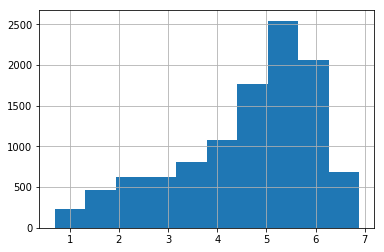

In [25]:
df['count'].map(np.log1p).hist()

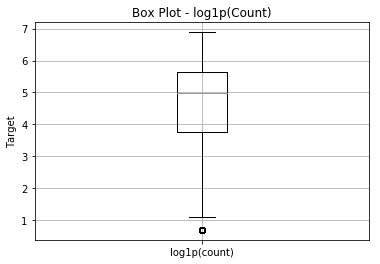

In [26]:
# Let's see how the data distribution changes with log1p
plt.boxplot([df['count'].map(np.log1p)], labels=['log1p(count)'])
plt.title('Box Plot - log1p(Count)')
plt.ylabel('Target')
plt.grid(True)

#### There are less outliers now after log transforming  as compared to before so lets make this change.

In [27]:
df["count"] = df["count"].map(np.log1p)
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,dayofweek,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,2.833213,2011,1,1,5,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,3.713572,2011,1,1,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,3.496508,2011,1,1,5,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,2.639057,2011,1,1,5,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,0.693147,2011,1,1,5,4


In [28]:
df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,dayofweek,hour
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,3,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,3,1
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,3,2
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,4


In [30]:
# Save all data
df.to_csv('bike_all.csv',index=False,
          columns=columns)

### Creating Training and Validation Set
 Target Variable as first column followed by input features <br>
 Training, Validation files do not have a column header

In [31]:
# Training = 70% of the data
# Validation = 30% of the data
# Randomize the datset
np.random.seed(5)
l = list(df.index)
np.random.shuffle(l)
df = df.iloc[l]

In [32]:
rows = df.shape[0]
train = int(.7 * rows)
test = int(.3 * rows)

In [33]:
rows, train, test

(10886, 7620, 3265)

In [34]:
columns

['count',
 'season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'month',
 'day',
 'dayofweek',
 'hour']

In [35]:
# Write Training Set
df[:train].to_csv('bike_train.csv'
                          ,index=False,header=False
                          ,columns=columns)

In [36]:
# Write Validation Set
df[train:].to_csv('bike_validation.csv'
                          ,index=False,header=False
                          ,columns=columns)

In [37]:
# Test Data has only input features
df_test.to_csv('bike_test.csv',index=False)

In [38]:
','.join(columns)

'count,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,dayofweek,hour'

Saving column list as well

In [39]:
# Write Column List
with open('bike_train_column_list.txt','w') as f:
    f.write(','.join(columns))

### Summary 
We have explored and prepared the data for modelling phase.